In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import pystan
import ruptures as rpt
import ruptures as rpt
import datetime as dt
import math
import scipy.special

C:\Users\Justin\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [46]:
def get_days(t1, t2):
    y1, y2 = int(t1), int(t2)
    if(y1 == y2):
        return int((t2-t1)*(366 if y2%4==0 else 365))
    else:
        return (366-274)
def get_prev_quarter(t):
    year = t//1
    days = int(round((t-year) * (366 if year%4==0 else 365)))
    if(days == 90 or days == 91):
        return year
    elif(days == 181):
        return year + 90/365
    elif(days == 182):
        return year + 91/366
    elif(days == 273):
        return year + 181/365
    elif(days == 274):
        return year + 182/366
    elif(days == 0):
        return ((year-1)+274/366) if ((year-1)%4==0) else ((year-1) + 273/365)
    else:
        print(days, t)

def smooth_trend(a, n):
    vals = []
    for i in range(len(a)):
        window = a[max(i-n,0):min(i+n+1, len(a))]
        vals.append(sum(window)/len(window))
    return np.array(vals)

'''
def get_temp_feature(temp_df):
    if(len(temp_df)<20):
        return 0
    else:
        temps = temp_df.Temperature.values
        dates = temp_df.Date.values
        smoothed = smooth_trend(temps, 5)
        diffed = np.diff(smoothed,1)
        algo = rpt.Pelt(model='rbf', min_size=5).fit(diffed)
        result = algo.predict(pen=5)
        if(len(result)!=1):
            return (smoothed[result[-1]]-smoothed[result[-2]]) / smoothed[result[-2]]#/ (dates[result[-1]] - dates[result[-2]])
        else:
            return 0
'''
def get_temp_feature(temp_df):
    if(len(temp_df)==0):
        return np.mean(trimmed_weather_df.Temperature.values)
    return np.mean(temp_df.Temperature.values)
def get_price_feature(food_df):
    return np.mean(food_df.Price.values/1e6)
'''

def get_price_feature(food_df):
    prices = food_df.Price.values
    dates = food_df.Date.values
    nVals = len(dates)
    if(nVals == 0):
        return 0.
    minD = minP = 1e10
    maxD = maxP = -1e10
    for i in range(nVals):
        (minD, minP) = (dates[i], prices[i]) if prices[i] < minP else (minD, minP)
        (maxD, maxP) = (dates[i], prices[i]) if prices[i] > maxP else (maxD, maxP)
    if(maxD == minD):
        return 0.
    else:
        #return  (maxP - minP) / (maxD - minD)# * (max(maxD, minD) - min(dates)) / (max(dates)-min(dates)) 
        if(maxD > minD):
            return (maxP-minP)/minP * (max(maxD, minD) - min(dates)) / (max(dates)-min(dates)) 
        else:
            return (minP-maxP)/maxP * (max(maxD, minD) - min(dates)) / (max(dates)-min(dates)) 

def get_fews_feature(food_df):
    prices = food_df.Price.values
    dates = food_df.Date.values
    nVals = len(dates)
    minD = minP = 1e10
    maxD = maxP = -1e10
    for i in range(nVals):
        (minD, minP) = (dates[i], prices[i]) if prices[i] < minP else (minD, minP)
        (maxD, maxP) = (dates[i], prices[i]) if prices[i] > maxP else (maxD, maxP)
    if(maxD == minD):
        return 0.
    else:
        return  (maxP - minP) / (maxD - minD)# * (max(maxD, minD) - min(dates)) / (max(dates)-min(dates)) 
'''        
#Constants:
WANTEDPRODUCTS = {'Rice (imported) - Retail':0, 'Maize (white) - Retail':1, 'Sorghum (red) - Retail':2}
#WANTEDPRODUCTS = {'Maize (white) - Retail':1}
WANTEDFEWSFOOD = {'Cowpeas (Red)'}
#WANTEDSTATIONS = {'EGAL INTL':0, 'MOGADISHU': 1, 'BOSASO':2}
WANTEDSTATIONS = {'EGAL INTL':0}



def strdate(s):
    date = dt.datetime.strptime(s, '%d %B %Y')
    year = date.date().year
    return year + (date.date().timetuple().tm_yday-1)/ (366 if year%4==0 else 365)

def applyProductMap(s):
    return WANTEDPRODUCTS[str(s)]


def dateToFloat(d):
    year= d//10000
    mo = (d%10000)//100 - 1
    day = d%100 - 1
    if(year%4==0):
        return year+(LEAPS[mo]+day)/366
    else:
        return year+(MONTHS[mo]+day)/365
    
def applyStationMap(s):
    return WANTEDSTATIONS[str(s)]

In [139]:
famine_model_code = '''
data {
    int<lower=0> N;
    int<lower=0> K;
    matrix[N, K] feats;
    vector[N] response;
}
parameters{
    real alpha;
    real<lower=0> beta;
    vector[K] coeffs;
    real<lower=0> sigma;
}
model {
    response[2:N] ~ lognormal(alpha + beta*response[1:(N-1)] + (feats[2:N])*coeffs, sigma);
    coeffs ~ normal(0, 1);
    beta ~ normal(1,1);
    alpha ~ normal(0,1);
}'''

new_famine_model = pystan.StanModel(model_code= famine_model_code, model_name="famine_model")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL famine_model_590573dd2dc8da7b70d5cd086cb54437 NOW.


In [125]:
mult_model_code = '''
data {
    int<lower=0> N;
    int<lower=0> K;
    matrix[N, K] feats;
    vector[N] response;
}
parameters{
    real alpha;
    real beta;
    vector[K] coeffs;
    real<lower=0> sigma;
}
model{
    vector[N] mults;
    mults[2:N] = beta*response[1:(N-1)];
    for (i in 1:K) {
        mults[2:N] = mults[2:N].*(1+coeffs[i]*feats[2:N,i]);
    }
    response[2:N] ~ normal(alpha + mults[2:N], sigma);
}'''
mult_model = pystan.StanModel(model_code= mult_model_code, model_name="mult_model")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL mult_model_cd7ae9607f799d4ec0bc8fce91e3c2c4 NOW.


In [32]:
beta_model_code = '''
data {
    int<lower=0> N;
    int<lower=0> K;
    matrix[N,K] feats;
    vector[N] response;
}

parameters{
    real alpha;
    real beta;
    real<lower=0> kappa;
    vector[K] coeffs;
}

model{
    vector[N] mus;
    mus[2:N] = inv_logit(alpha + beta*response[1:(N-1)] +feats[2:N]*coeffs);
    response[2:N] ~ beta_proportion(mus[2:N], kappa);
}
'''
beta_model = pystan.StanModel(model_code=beta_model_code, model_name="beta_model")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL beta_model_8ea23b79f37f28f3834d00c4c1a09eb9 NOW.


[0.014333333333333332, 0.009, 0.008666666666666666, 0.02783333333333333, 1.2391304347826086, 74.7414150129422]
[0.014, 0.009, 0.008, 0.019166666666666665, -1.9555555555555555, 74.7414150129422]
[0.015300000000000001, 0.01255, 0.008, 0.02993333333333333, -3.522222222222222, 76.56666666666666]
[0.015333333333333332, 0.010666666666666666, 0.008666666666666668, 0.029333333333333333, -0.4945054945054945, 80.048]
[0.017666666666666667, 0.013638999999999998, 0.010866666666666669, 0.03233333333333333, 0.532608695652174, 71.91829268292682]
[0.016866666666666665, 0.014726666666666666, 0.016, 0.04238333333333333, -0.48314606741573035, 71.8590361445783]
[0.01783766666666667, 0.015846166666666668, 0.021462666666666668, 0.057333333333333326, -1.1538461538461537, 80.18777777777778]
[0.017194333333333336, 0.014417, 0.02369, 0.056666666666666664, -1.3516483516483517, 77.75217391304349]
[0.017750000000000002, 0.010208333333333333, 0.01375, 0.03195, 1.0108695652173914, 71.21304347826087]
[0.016825, 0.009

Inference for Stan model: beta_model_8ea23b79f37f28f3834d00c4c1a09eb9.
4 chains, each with iter=3000; warmup=1500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=6000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha        1.15    0.09   3.82  -6.42  -1.24    1.1   3.59   8.93   1904    1.0
beta      -9.6e-4     0.1   4.27  -8.44  -2.68  -0.05   2.56   8.85   1661    1.0
kappa       70.73    0.87  34.72  20.82   44.8   64.4  90.66 149.58   1603    1.0
coeffs[1]   83.47    3.87 162.56 -251.1  -15.1  85.96 183.13 408.46   1762    1.0
coeffs[2]   49.41    2.39 101.58 -150.7 -13.47  47.03  112.3  258.4   1803    1.0
coeffs[3]  -56.96     1.7   79.8 -216.5 -106.8 -54.79  -6.52 103.32   2196    1.0
coeffs[4]   64.27    1.05  50.81 -33.78  32.04  62.91  96.02 168.05   2347    1.0
coeffs[5]     0.1  2.0e-3   0.11  -0.12   0.04    0.1   0.17    0.3   2734    1.0
coeffs[6]   -0.08  1.0e-3   0.05  -0.18  -0.11  -0.08  -0.05   0.02   213

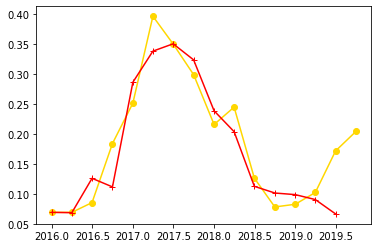

In [48]:
REGION = "Hiraan"
STARTTIME = 2016
PHASE = 3
#Transform food data:
food_df = pd.read_csv('data/food.csv', usecols = [0,1,3,4])
food_df = food_df[food_df.Region.eq(REGION) & food_df.Date.ge(STARTTIME-1) & food_df.Item.isin(WANTEDPRODUCTS)]
food_df['ItemID'] = food_df['Item'].apply(applyProductMap)
trimmed_food_df = food_df[['Date', 'ItemID', 'Price']]

#Extract FEWSNET food data
ffood_df = pd.read_csv('data/fews_food.csv')
ffood_df = ffood_df[ffood_df.date.ge(STARTTIME-1) & ffood_df.item.isin(WANTEDFEWSFOOD) & ffood_df.region.eq(REGION)]
ffood_df = ffood_df.rename(columns = {'price': 'Price', 'date':'Date'})

#Extract conflict data
conflict_df = pd.read_csv("data/conflict.csv")
conflict_df = conflict_df[['event_date', 'admin1', 'fatalities']].rename(columns={'admin1':'region'})
conflict_df['date'] = conflict_df.event_date.apply(strdate)
trimmed_conflict_df = conflict_df[conflict_df.date.ge(STARTTIME-1) & conflict_df.region.eq(REGION)][['date','region','fatalities']]
#trimmed_conflict_df =conflict_df

#Extract IPC data
ipc_df = pd.read_csv('data/ipc-5y.csv')
trimmed_ipc_df = ipc_df[ipc_df.time.ge(STARTTIME) & ipc_df.region.eq(REGION)]

#Extract weather data
weather_df = pd.read_csv('data/climate-complete-noaa.csv', usecols = [0,3,4])
weather_df = weather_df[weather_df['Station Name'].isin(WANTEDSTATIONS)]
weather_df['Date'] = weather_df['Date'].apply(dateToFloat)
weather_df = weather_df[weather_df.Date.ge(STARTTIME-1)]
weather_df['Station Name'] = weather_df['Station Name'].apply(applyStationMap)
trimmed_weather_df = weather_df.rename(columns={'Station Name':'Station', 'Mean Temperature':'Temperature'})

dates = sorted(list(set(trimmed_ipc_df.time.values)))

datasets = dict()
for date in dates:
    prev_q = get_prev_quarter(date)
    dataset = dict()
    features = []
    dataset['ipc']= trimmed_ipc_df.loc[trimmed_ipc_df.time.eq(date), ['p2perc', 'p3perc', 'p4perc','idp_pop']].to_dict('records')
    
    
    #features.append(np.mean(trimmed_ipc_df.loc[trimmed_ipc_df.time.eq(date), ['idp_pop']].values)/1e6)
    food_data = dict()
    for i in range(len(WANTEDPRODUCTS)):
        food_data[i] = trimmed_food_df[trimmed_food_df.Date.ge(prev_q) & trimmed_food_df.Date.lt(date) & trimmed_food_df.ItemID.eq(i)][['Date','ItemID', 'Price']]
        features.append(get_price_feature(food_data[i]))
        #features.append(lst_sq(food_data[i])[0])
        #features.append(lst_sq(food_data[i])[1])
    
    fews_data = dict()
    for food in WANTEDFEWSFOOD:
        food_data[food] = ffood_df[ffood_df.Date.ge(prev_q) & ffood_df.Date.lt(date) & ffood_df.item.eq(food)]
        features.append(get_price_feature(food_data[food]))
        #features.append(lst_sq(food_data[food])[0])
        #features.append(lst_sq(food_data[food])[1])
    
    dataset['food'] = food_data
    
    conflict_data = trimmed_conflict_df[trimmed_conflict_df.date.ge(prev_q)&trimmed_conflict_df.date.lt(date)]
    features.append(np.sum(conflict_data.fatalities.values)/get_days(date,prev_q))
    
    dataset['conflict'] = conflict_data
    
    weather_data = dict()
    for i in range(len(WANTEDSTATIONS)):
        weather_data[i] = trimmed_weather_df[trimmed_weather_df.Date.ge(prev_q) & trimmed_weather_df.Date.lt(date) & trimmed_weather_df.Station.eq(i)][['Date','Temperature']]
        #features['t{}'.format(i)]=get_temp_feature(weather_data[i])
        features.append(get_temp_feature(weather_data[i]))
    dataset['weather']=weather_data
    dataset['features']=features
    print(dataset['features'])
    datasets[date] = dataset
    
    
train_dates =sorted(list (datasets.keys()))[:-2]
nFeatures = len(datasets[train_dates[0]]['features'])
features = [datasets[date]['features'] for date in train_dates]
idp_pops = [datasets[date]['ipc'][0]['idp_pop'] for date in train_dates]

response = [datasets[date]['ipc'][0]['p{}perc'.format(PHASE)] for date in train_dates]
famine_model_data = dict(
    N = len(train_dates),
    K = nFeatures,
    feats = features,
    #idp_pop = idp_pops,
    response = response
)


result = beta_model.sampling(data=famine_model_data, iter=3000, control = dict(max_treedepth=12, adapt_delta=0.8))
print(result)

#coeffs = list(map(lambda x: sum(x)/len(x), result.get_posterior_mean()[:nFeatures+2]))
coeffs = list(map(lambda x: sum(x)/len(x), result.get_posterior_mean()[:nFeatures+3]))
print(coeffs)
def generate(coeffs, datasets):
    times = sorted(list(datasets.keys()))
    pred_ipc = []
    
    for (i,time) in enumerate(times):
        new_ipc = scipy.special.expit(coeffs[0]+sum(np.multiply(coeffs[2:], datasets[time]['features'])))
        pred_ipc.append(new_ipc)
    return pred_ipc

def generate_ar(coeffs, datasets):
    times = sorted(list(datasets.keys()))
    pred_ipc = [datasets[times[0]]['ipc'][0]['p{}perc'.format(PHASE)]]
    for time in times[1:]:
        new_ipc = scipy.special.expit(coeffs[0]+pred_ipc[-1]*coeffs[1]+sum(np.multiply(coeffs[3:], datasets[time]['features'])))
        pred_ipc.append(new_ipc)
    return pred_ipc
    
times = sorted(list(datasets.keys()))
gold_ipcs = [datasets[date]['ipc'][0]['p{}perc'.format(PHASE)] for date in times]
pred_ipcs = generate_ar(coeffs, datasets)
plt.plot(times, gold_ipcs, marker='o', color='gold')
plt.plot(times,pred_ipcs, marker='+', color='red')
plt.show()

In [11]:
coeffs

[-2.169120850656,
 202865089739.8046,
 13.754735282356265,
 2.0454572548496737,
 -0.8215122039650802,
 0.7494141264550314,
 0.8667114096546427,
 0.18088273467382085,
 0.007799394286873428]

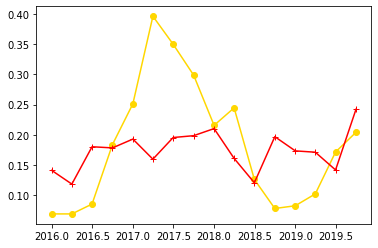